<h1>Sudoku Solving Agents!</h1>

Arjun Phull, ISTA 450 Final Project, 13 December 2023

In [1]:
from main import *

<code>main.py</code> implements the class <code>SudokuGame</code> and three solving algorithms. This notebook explains how to use them and compares their performance.

Let's first define some Sudoku boards:

In [2]:
# load in pre-generated sudoku boards
with open('testBoards.pickle', 'rb') as file:
    boards = pickle.load(file)

board1 = boards[20][1].copy()
board1

array([[5, '_', 4, '_', 7, 8, '_', '_', 2],
       ['_', '_', 2, '_', 9, '_', 3, 4, 8],
       [1, 9, 8, '_', 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, '_', '_', 2, 3],
       [4, 2, 6, '_', 5, '_', 7, '_', 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, '_', 7, 2, '_', 4],
       ['_', 8, 7, 4, 1, 9, 6, 3, 5],
       [3, '_', '_', '_', 8, 6, 1, 7, 9]], dtype=object)

<code>board1</code> is a partially filled Sudoku board with 20 open cells. <code>sol1</code> is its solution. We can import this board into a <code>SudokuGame</code> easily:

In [3]:
game = SudokuGame(board1.copy())
game.printBoard()

 5  _  4  _  7  8  _  _  2
 _  _  2  _  9  _  3  4  8
 1  9  8  _  4  2  5  6  7
 8  5  9  7  6  _  _  2  3
 4  2  6  _  5  _  7  _  1
 7  1  3  9  2  4  8  5  6
 9  6  1  5  _  7  2  _  4
 _  8  7  4  1  9  6  3  5
 3  _  _  _  8  6  1  7  9


The first solving algorithm is local search, implemented in <code>minConflicts</code>. This algorithm randomly assigns values to each empty cell. Then, it chooses a random cell and changes its value to the value that minimizes the total amount of conflicts. The algorithm repeats until a solution is found or a maximum number of iterations is reached.

In [4]:
game1 = SudokuGame(board1.copy())

# run minConflicts
conflictLog = minConflicts(game1, maxSteps=5000, plateauThreshold=20)

minConflicts:   1%|▏         | 71/5000 [00:00<00:16, 304.03it/s]

Solved the board in 71 steps.
 5  3  4  6  7  8  9  1  2
 6  7  2  1  9  5  3  4  8
 1  9  8  3  4  2  5  6  7
 8  5  9  7  6  1  4  2  3
 4  2  6  8  5  3  7  9  1
 7  1  3  9  2  4  8  5  6
 9  6  1  5  3  7  2  8  4
 2  8  7  4  1  9  6  3  5
 3  4  5  2  8  6  1  7  9


<code>minConflicts</code> relies on random choice, so finding the solution to the same Sudoku board may take drastically different amounts of steps between runs. Additionally, since the assignments are random, <code>minConflicts</code> may never actually find the solution.

A more efficient approach is backtracking, as implemented in <code>backtrackingSearch</code>. This algorithm recursively assigns values to the first empty cell on the board. If a value assignment causes a conflict, the algorithm backtracks, reverses the assignment, and tries a new variable. Backtracking is guaranteed to find a solution!

In [5]:
game2 = SudokuGame(board1.copy())

# run backtracking
solution, timeElapsed = backtrackingSearch(game2)
print(f"Backtracking found the solution in {timeElapsed} seconds.")

Solution found in 20 steps!
 5  3  4  6  7  8  9  1  2
 6  7  2  1  9  5  3  4  8
 1  9  8  3  4  2  5  6  7
 8  5  9  7  6  1  4  2  3
 4  2  6  8  5  3  7  9  1
 7  1  3  9  2  4  8  5  6
 9  6  1  5  3  7  2  8  4
 2  8  7  4  1  9  6  3  5
 3  4  5  2  8  6  1  7  9
Backtracking found the solution in 0.006609201431274414 seconds.


Unlike <code>minConflicts</code>, backtracking can easily handle complex puzzles, such as this Sudoku board with 57 blank spaces:

In [6]:
board2 = boards[57][1]

game3 = SudokuGame(board2.copy())
game3.printBoard()
print('\n')

# run backtracking
solution, timeElapsed = backtrackingSearch(game3)
print(f"Backtracking found the solution in {timeElapsed} seconds.")

 5  _  4  6  _  _  _  1  2
 _  _  _  _  _  _  _  _  _
 _  9  _  3  4  _  _  _  _
 _  5  _  _  _  _  _  _  _
 _  2  6  _  5  _  _  9  _
 7  _  _  _  2  _  _  _  6
 _  _  1  5  _  7  _  _  _
 _  _  7  _  _  _  _  3  _
 3  _  _  _  _  _  1  7  _


Solution found in 57 steps!
 5  3  4  6  7  8  9  1  2
 1  7  8  2  9  5  3  6  4
 6  9  2  3  4  1  5  8  7
 4  5  9  1  8  6  7  2  3
 8  2  6  7  5  3  4  9  1
 7  1  3  4  2  9  8  5  6
 2  8  1  5  3  7  6  4  9
 9  6  7  8  1  4  2  3  5
 3  4  5  9  6  2  1  7  8
Backtracking found the solution in 0.09726405143737793 seconds.


Backtracking search is much faster than minConflicts, and it's guaranteed to find a solution. However, it fills in each empty value in order of its appearance on the board. While this is a consistent approach, it might not be the most efficient...

...which brings us to the last solver agent: <code>constraintProp</code>. This algorithm keeps record of all possible candidates for each empty cell on the board. Then, it recursively assigns values to the cell with the fewest candidate, and *propagates* the *constraints* after each assignment.

In [17]:
game4 = SudokuGame(board2.copy())

# run constraint propagation
solution, timeElapsed = constraintProp(game4)
print(f"Constraint propagation found the solution in {timeElapsed} seconds.")

Solution found in 57 steps.
 5  3  4  6  7  8  9  1  2
 1  7  8  2  9  5  4  6  3
 6  9  2  3  4  1  8  5  7
 8  5  9  7  6  4  3  2  1
 4  2  6  1  5  3  7  9  8
 7  1  3  8  2  9  5  4  6
 2  4  1  5  3  7  6  8  9
 9  8  7  4  1  6  2  3  5
 3  6  5  9  8  2  1  7  4
Constraint propagation found the solution in 0.04378795623779297 seconds.


<code>constraintProp</code> is observably faster than backtracking! To see how each of these algorithms compare, we can run some trials and plot the performance of each.

<h3>Comparing Performance</h3>

The file <code>testBoards.pickle</code> contains a dictionary called <code>boards</code>. The keys of <code>boards</code> represent a certain number of missing spaces on a Sudoku board (i.e. a way to quantify the difficulty of the board). Each key maps to a list of ten boards with that many spaces missing.

Note: <code>boards</code> only contains Sudoku boards with up to 57 blank spaces. This is because the New York Times' "hard" Sudoku puzzle has a maximum of 57 blank spaces :)

The code used to generate <code>boards</code> is in the cell below:

In [19]:
## Code used to generate solvable test boards
# 
# testBoards = {i: list() for i in range(1,57)}
# 
# for i in range(1,57):
#     while len(testBoards[i]) < 10:
#         game = SudokuGame(redactCells(sol1, i))
#         board = copy.deepcopy(game.board)
#         solution = backtrackingSearch(game)
#         if solution is not None:
#             testBoards[i].append(board)
# 
# with open('testBoards.pickle', 'wb') as file:
#     pickle.dump(testBoards, file, protocol=pickle.HIGHEST_PROTOCOL)

To test the performance of local search, we can run <code>minConflicts</code> on each board and store the results in a <code>DataFrame</code>. The commented code below shows how to do this; but since this process took almost an hour to run, I've also included a CSV with the formatted data.

In [22]:
# minConflictRuns = pd.DataFrame(columns=['boardSize', 'conflicts'], index=np.arange(300))
# run = 0
# for size in tqdm(boards, desc="Sizes"):
#     for i in tqdm(range(10), desc=f"Iterating over size {size}"):
#         game = SudokuGame(boards[size][i].copy())
#         minConflictRuns.boardSize[run] = size
#         minConflictRuns.conflicts[run] = minConflicts(game, maxSteps=5000, plateauThreshold=20, printOutput=False)
#         run += 1

# for i in minConflictRuns.index:
#     if minConflictRuns.loc[i, 'conflicts'][-1] == 0:
#         minConflictRuns.loc[i, 'success'] = True  # create a success column
#     minConflictRuns.loc[i, 'steps'] = len(minConflictRuns.loc[i, 'conflicts'])  # get the number of steps

# minConflictRuns.to_csv('minConflictRuns.csv')

minConflictRuns = pd.read_csv('minConflictRuns.csv', index_col=0)
minConflictRuns

,boardSize,conflicts,success,steps
0,1,"[6, 0]",True,2
1,1,"[6, 0]",True,2
2,1,"[6, 0]",True,2
3,1,"[6, 0]",True,2
4,1,"[6, 0]",True,2
...,...,...,...,...
295,30,"[126, 126, 124, 122, 116, 112, 108, 106, 106, ...",False,5000
296,30,"[128, 124, 124, 120, 116, 114, 114, 110, 106, ...",False,5000
297,30,"[134, 132, 122, 120, 116, 104, 104, 104, 104, ...",True,1178
298,30,"[160, 152, 146, 134, 132, 132, 128, 128, 124, ...",True,782


Let's plot the average number of steps that <code>minConflicts</code> took for each puzzle.

Text(0, 0.5, 'Average steps taken')

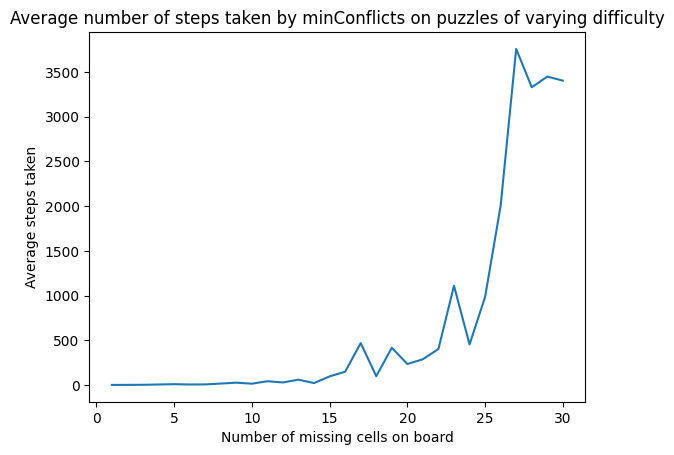

In [23]:
plt.plot(minConflictRuns.groupby('boardSize')['steps'].mean())
plt.title('Average number of steps taken by minConflicts on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Average steps taken')